# Imports and Global Configuration

In [9]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.alpha"] = 0.3

# Helper functions: Metrics and ROC

In [10]:
def confusion_from_scores(y_true, y_score, thr=0.5):
    y_pred = (y_score >= thr).astype(int)
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == 0) & (y_pred == 0)))
    fp = int(np.sum((y_true == 0) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == 0)))
    return tp, tn, fp, fn


def classification_metrics(y_true, y_score, thr=0.5):
    tp, tn, fp, fn = confusion_from_scores(y_true, y_score, thr)
    acc = (tp + tn) / max(1, (tp + tn + fp + fn))
    prec = tp / max(1, (tp + fp))
    rec = tp / max(1, (tp + fn))
    return acc, prec, rec, (tp, tn, fp, fn)


def roc_curve_points(y_true, y_score):
    thresholds = np.unique(y_score)[::-1]
    thresholds = np.r_[thresholds, -np.inf]
    P = max(1, int(np.sum(y_true == 1)))
    N = max(1, int(np.sum(y_true == 0)))

    tpr_list, fpr_list = [], []
    for thr in thresholds:
        tp, tn, fp, fn = confusion_from_scores(y_true, y_score, thr)
        tpr = tp / P
        fpr = fp / N
        tpr_list.append(tpr)
        fpr_list.append(fpr)

    fpr = np.array(fpr_list)
    tpr = np.array(tpr_list)
    order = np.argsort(fpr)
    auc = np.trapz(tpr[order], fpr[order])
    return fpr, tpr, auc


def plot_roc(y_true, y_score, title):
    fpr, tpr, auc = roc_curve_points(y_true, y_score)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{title} (AUC={auc:.4f})")
    plt.grid(True, alpha=0.3)
    plt.show()

# Helper functions: Data Generation and Visualization

In [11]:
def generate_data_via_provided_script(seed=0):
    rng = np.random.default_rng(seed)
    N1 = 300
    N2 = 80
    sigma = 2

    mean1 = np.array([10, 14])
    cov1 = np.array([[sigma, 0], [0, sigma]])
    X1 = rng.multivariate_normal(mean1, cov1, N1)

    mean2 = np.array([14, 18])
    cov2 = np.array([[sigma, 0], [0, sigma]])
    X2 = rng.multivariate_normal(mean2, cov2, N2)

    X = np.vstack([X1, X2])
    T = np.array([0] * N1 + [1] * N2, dtype=int)

    return X, T, X1, X2


def normalize_data(X):
    X_mean = X.mean(axis=0)
    X_std = X.std(axis=0) + 1e-8
    X_norm = (X - X_mean) / X_std
    return X_norm, X_mean, X_std


def show_scatter(X1, X2, title="Generated data scatter"):
    plt.figure()
    plt.scatter(X1[:, 0], X1[:, 1], marker='o', label="Class 1 (t=0)")
    plt.scatter(X2[:, 0], X2[:, 1], marker='o', label="Class 2 (t=1)")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Question 1: MLP Model Definition and Training

In [12]:
def relu(x):
    return np.maximum(0, x)


def relu_deriv(x):
    return (x > 0).astype(float)


def sigmoid(x):
    x = np.clip(x, -50, 50)
    return 1.0 / (1.0 + np.exp(-x))


class MLP:
    def __init__(self, seed=0, w_std=1):
        rng = np.random.default_rng(seed)
        self.W1 = rng.normal(0, w_std, size=(2, 3))
        self.b1 = rng.normal(0, w_std / 2, size=(3,))
        self.W2 = rng.normal(0, w_std, size=(3, 1))
        self.b2 = rng.normal(0, w_std / 2, size=(1,))

    def forward(self, X):
        z1 = X @ self.W1 + self.b1
        a1 = relu(z1)
        z2 = a1 @ self.W2 + self.b2
        y = sigmoid(z2).reshape(-1)
        cache = (X, z1, a1, z2, y)
        return y, cache

    def predict_score(self, X):
        y, _ = self.forward(X)
        return y

    def batch_backprop_update(self, X, T, lr=0.001, l2=0.0):
        y, cache = self.forward(X)
        Xc, z1, a1, z2, yv = cache

        t = T.astype(float)
        delta2 = (yv - t)

        dW2 = (a1.T @ delta2.reshape(-1, 1)) / X.shape[0]
        db2 = np.mean(delta2)

        delta1 = (delta2.reshape(-1, 1) @ self.W2.T) * relu_deriv(z1)
        dW1 = (X.T @ delta1) / X.shape[0]
        db1 = np.mean(delta1, axis=0)

        dW2 += l2 * self.W2
        dW1 += l2 * self.W1

        self.W2 -= lr * dW2
        self.b2 -= lr * db2
        self.W1 -= lr * dW1
        self.b1 -= lr * db1

# Question 1: MLP Evaluation and Plots

In [13]:
def plot_decision_boundary_score(model_score_fn, X, T, title, thr=0.5, grid_steps=250):
    x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
    y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
    xs = np.linspace(x_min, x_max, grid_steps)
    ys = np.linspace(y_min, y_max, grid_steps)
    XX, YY = np.meshgrid(xs, ys)
    grid = np.c_[XX.ravel(), YY.ravel()]

    score = model_score_fn(grid).reshape(XX.shape)

    plt.figure()
    plt.contour(XX, YY, score, levels=[thr])
    plt.scatter(X[T == 0, 0], X[T == 0, 1], marker='o', label="Class 1 (t=0)")
    plt.scatter(X[T == 1, 0], X[T == 1, 1], marker='o', label="Class 2 (t=1)")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def mlp_evaluate_and_plot(X, T, seed=2, w_std=0.6, epochs=1000, lr=0.02, l2=0.001):
    mlp = MLP(seed=seed, w_std=w_std)

    y_init = mlp.predict_score(X)
    acc, prec, rec, cm = classification_metrics(T, y_init, thr=0.5)
    print("Part 1b (Initial MLP) metrics @thr=0.5")
    print(f"  Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, (TP,TN,FP,FN)={cm}")

    plot_decision_boundary_score(
        mlp.predict_score, X, T,
        title="Part 1b: Initial MLP decision boundary (contour at 0.5)",
        thr=0.5
    )
    plot_roc(T, y_init, title="Part 1b: Initial MLP ROC")

    for _ in range(epochs):
        mlp.batch_backprop_update(X, T, lr=lr, l2=l2)

    y_trained = mlp.predict_score(X)
    acc2, prec2, rec2, cm2 = classification_metrics(T, y_trained, thr=0.5)
    print("\nPart 1c (Updated MLP) metrics @thr=0.5")
    print(f"  Accuracy={acc2:.4f}, Precision={prec2:.4f}, Recall={rec2:.4f}, (TP,TN,FP,FN)={cm2}")

    plot_decision_boundary_score(
        mlp.predict_score, X, T,
        title="Part 1c: Updated MLP decision boundary (contour at 0.5)",
        thr=0.5
    )
    plot_roc(T, y_trained, title="Part 1c: Updated MLP ROC")

    return {
        "mlp": mlp,
        "initial": (acc, prec, rec, cm),
        "trained": (acc2, prec2, rec2, cm2),
        "y_init": y_init,
        "y_trained": y_trained,
    }

# Question 2: RBF Network Definition and Least Squares Fit

In [14]:
def rbf_design_matrix(X, centers, sigma=1.0, add_bias=True):
    X2 = np.sum(X**2, axis=1, keepdims=True)
    C2 = np.sum(centers**2, axis=1, keepdims=True).T
    dist2 = X2 - 2 * (X @ centers.T) + C2
    Phi = np.exp(-dist2 / (2 * sigma**2))
    if add_bias:
        Phi = np.c_[np.ones((X.shape[0], 1)), Phi]
    return Phi


def solve_ls_normal_eq(Phi, t, ridge=1e-8):
    t = t.astype(float).reshape(-1, 1)
    A = Phi.T @ Phi
    I = np.eye(A.shape[0])
    w = np.linalg.inv(A + ridge * I) @ (Phi.T @ t)
    return w.reshape(-1)


class RBFNet:
    def __init__(self, centers, sigma=1.0):
        self.centers = np.array(centers, dtype=float)
        self.sigma = float(sigma)
        self.w = None

    def fit_ls(self, X, T):
        Phi = rbf_design_matrix(X, self.centers, sigma=self.sigma, add_bias=True)
        self.w = solve_ls_normal_eq(Phi, T)

    def predict_score(self, X):
        Phi = rbf_design_matrix(X, self.centers, sigma=self.sigma, add_bias=True)
        y_lin = Phi @ self.w
        y_lin = np.clip(y_lin, -10, 10)
        return sigmoid(y_lin)


def random_centers_within_data_range(X, M, seed=0):
    rng = np.random.default_rng(seed)
    mins = X.min(axis=0)
    maxs = X.max(axis=0)
    centers = rng.uniform(mins, maxs, size=(M, X.shape[1]))
    return centers

# Question 2: RBF Evaluation and Plots

In [15]:
def plot_rbf_centers(X, T, centers, title):
    plt.figure()
    plt.scatter(X[T == 0, 0], X[T == 0, 1], marker='o', label="Class 1 (t=0)")
    plt.scatter(X[T == 1, 0], X[T == 1, 1], marker='o', label="Class 2 (t=1)")
    plt.scatter(centers[:, 0], centers[:, 1], marker='X', s=120, label="RBF centers")
    plt.title(title)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


def rbf_evaluate_and_plot(X, T, M, seed, sigma, title_prefix):
    centers = random_centers_within_data_range(X, M=M, seed=seed)
    rbf = RBFNet(centers=centers, sigma=sigma)
    rbf.fit_ls(X, T)

    plot_rbf_centers(X, T, centers, title=f"{title_prefix}: RBF centers (M={M})")

    y_rbf = rbf.predict_score(X)
    acc, prec, rec, cm = classification_metrics(T, y_rbf, thr=0.5)
    print(f"\n{title_prefix} (RBF M={M}) metrics @thr=0.5")
    print(f"  Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, (TP,TN,FP,FN)={cm}")

    plot_decision_boundary_score(
        rbf.predict_score, X, T,
        title=f"{title_prefix}: RBF (M={M}) decision boundary (contour at 0.5)",
        thr=0.5
    )
    plot_roc(T, y_rbf, title=f"{title_prefix}: RBF (M={M}) ROC")

    return {
        "rbf": rbf,
        "centers": centers,
        "metrics": (acc, prec, rec, cm),
        "y_score": y_rbf,
    }

# Helper function: Run All Experiments and Summary Prints

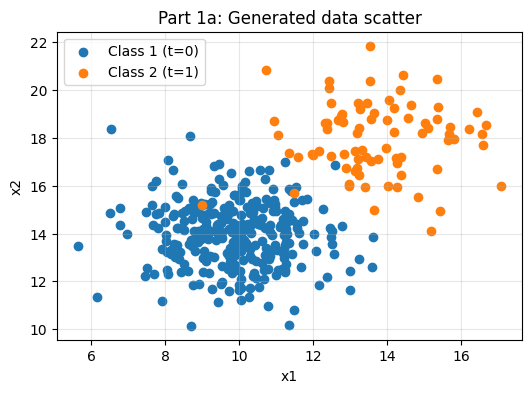

Part 1b (Initial MLP) metrics @thr=0.5
  Accuracy=0.7263, Precision=0.4310, Recall=0.9375, (TP,TN,FP,FN)=(75, 201, 99, 5)


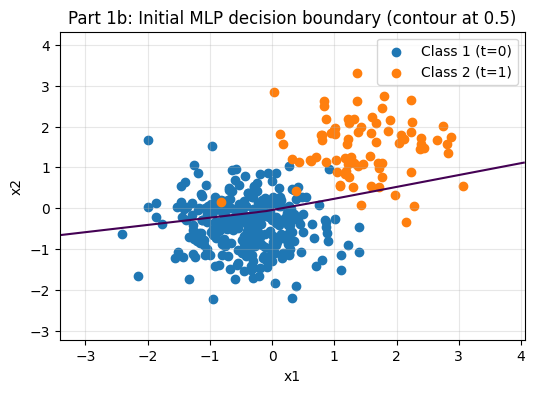

/var/folders/bf/qldgcnl14gx3s6tl46s9565c0000gn/T/ipykernel_49899/2997498347.py:35: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr[order], fpr[order])


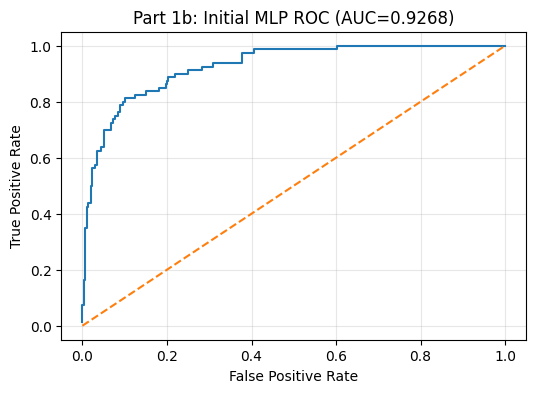


Part 1c (Updated MLP) metrics @thr=0.5
  Accuracy=0.9868, Precision=0.9747, Recall=0.9625, (TP,TN,FP,FN)=(77, 298, 2, 3)


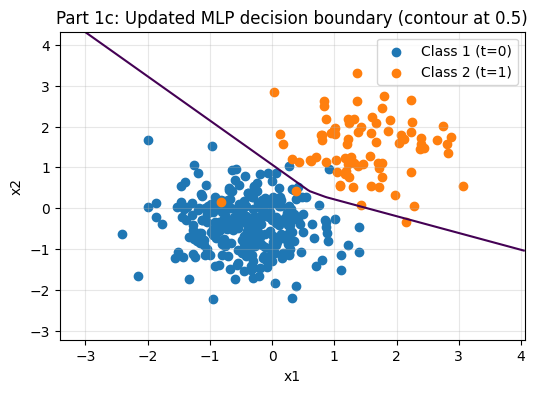

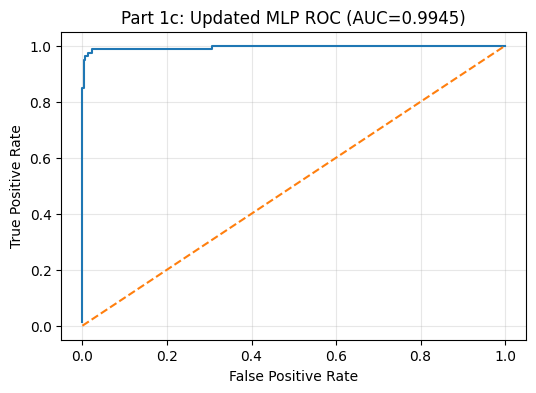

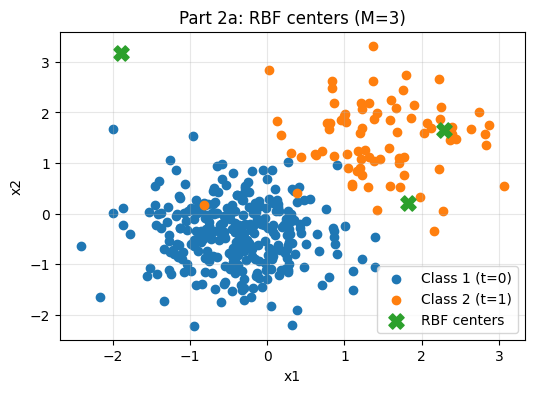


Part 2a (RBF M=3) metrics @thr=0.5
  Accuracy=0.3500, Precision=0.2446, Recall=1.0000, (TP,TN,FP,FN)=(80, 53, 247, 0)


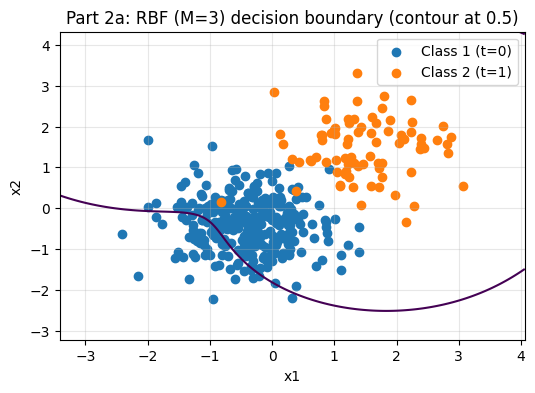

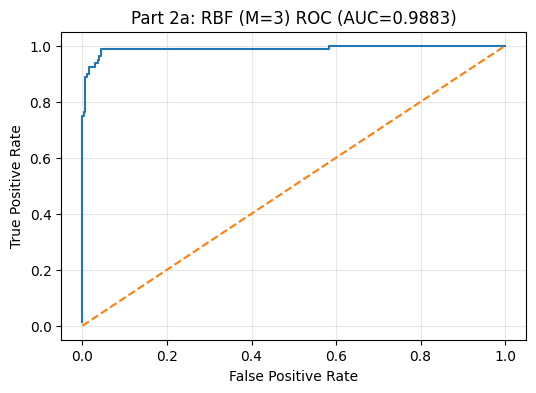

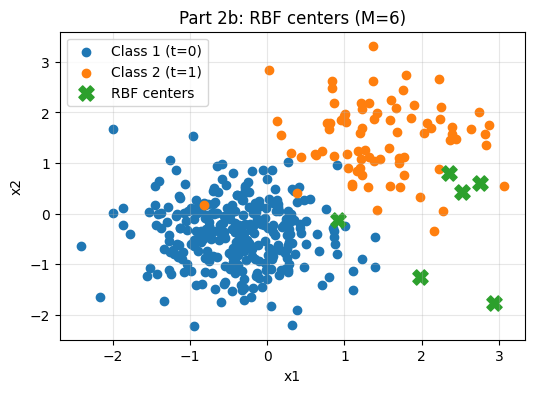


Part 2b (RBF M=6) metrics @thr=0.5
  Accuracy=0.6421, Precision=0.3692, Recall=0.9875, (TP,TN,FP,FN)=(79, 165, 135, 1)


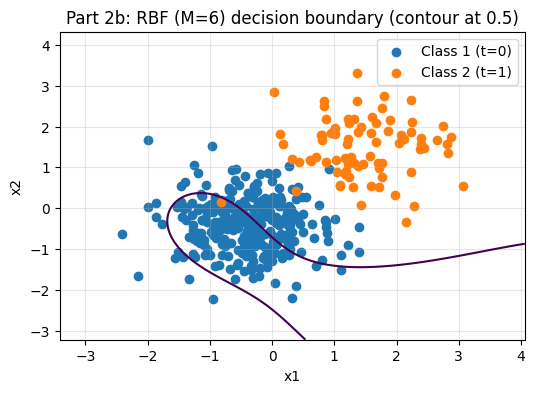

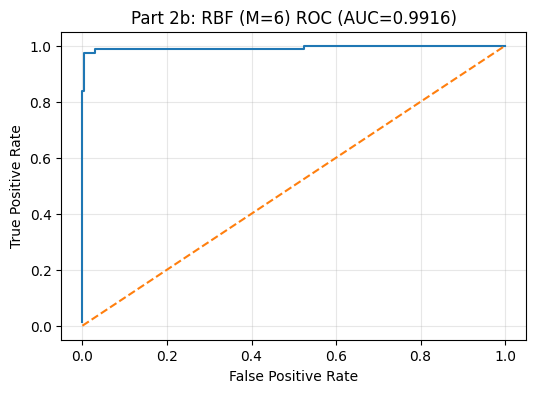


=== Quick comparison summary ===
Initial MLP:  acc=0.7263,  prec=0.4310,  rec=0.9375
Updated MLP:  acc=0.9868, prec=0.9747, rec=0.9625
RBF (M=3):    acc=0.3500,  prec=0.2446,  rec=1.0000
RBF (M=6):    acc=0.6421,  prec=0.3692,  rec=0.9875


In [16]:
# Part 1a: Generate + scatter
X, T, X1, X2 = generate_data_via_provided_script(seed=1)
X_norm, X_mean, X_std = normalize_data(X)
show_scatter(X1, X2, title="Part 1a: Generated data scatter")

# Part 1b/1c: MLP initial + trained
mlp_results = mlp_evaluate_and_plot(X_norm, T, seed=2, w_std=0.6, epochs=1000, lr=0.02, l2=0.001)

# Part 2a: RBF M=3
rbf3_results = rbf_evaluate_and_plot(X_norm, T, M=3, seed=42, sigma=1.0, title_prefix="Part 2a")

# Part 2b: RBF M=6
rbf6_results = rbf_evaluate_and_plot(X_norm, T, M=6, seed=4, sigma=3.0, title_prefix="Part 2b")

# Summary
acc, prec, rec, _ = mlp_results["initial"]
acc2, prec2, rec2, _ = mlp_results["trained"]
acc3, prec3, rec3, _ = rbf3_results["metrics"]
acc4, prec4, rec4, _ = rbf6_results["metrics"]

print("\n=== Quick comparison summary ===")
print(f"Initial MLP:  acc={acc:.4f},  prec={prec:.4f},  rec={rec:.4f}")
print(f"Updated MLP:  acc={acc2:.4f}, prec={prec2:.4f}, rec={rec2:.4f}")
print(f"RBF (M=3):    acc={acc3:.4f},  prec={prec3:.4f},  rec={rec3:.4f}")
print(f"RBF (M=6):    acc={acc4:.4f},  prec={prec4:.4f},  rec={rec4:.4f}")